In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [6]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [7]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [8]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        B > 0, B = exp(-(D/A)*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)


100000


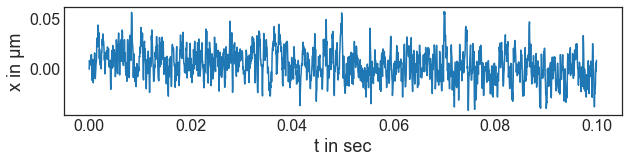

In [9]:
# load the data and subtract the mean
data = np.loadtxt("data_free/data_Free_passive_1.txt")*1.11
N = data.size
datan = data-data.mean()
delta_t = 1/20000
t = np.arange(N)*delta_t
plt.figure(figsize=(10,2))
plt.plot(t[:2000],datan[:2000])
plt.xlabel("t in sec")
plt.ylabel("x in µm")
print(N)

In [11]:
MLresults=OUresult2(datan,delta_t)
print("Amplitude = ",MLresults[0],"+/-",MLresults[1],"(",MLresults[1]/MLresults[0]*100,"%)")
print("decay = ",MLresults[2],"+/-",MLresults[3],"(",MLresults[3]/MLresults[2]*100,"%)")
print(np.exp(-delta_t/MLresults[2]))

Amplitude =  0.0002177954230014943 +/- 1.8552206497178508e-06 ( 0.8518180153423711 %)
decay =  0.00017671853992973346 +/- 1.7229318635795468e-06 ( 0.9749581816738733 %)
0.75356817165078


In [12]:
a_bound=0.001
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Uniform('A', lower=0, upper=a_bound)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=datan)
    
    trace = pm.sample(20000,tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 120000/120000 [08:12<00:00, 243.45draws/s]
The acceptance probability does not match the target. It is 0.6747778844065103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9116100284040408, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [13]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B,0.754,0.002,0.75,0.758,0.0,0.0,18988.0,18983.0,18970.0,23085.0,1.0
A,0.000,0.000,0.00,0.000,0.0,0.0,18774.0,18761.0,18779.0,22455.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f7b6730f0>,
      dtype=object)

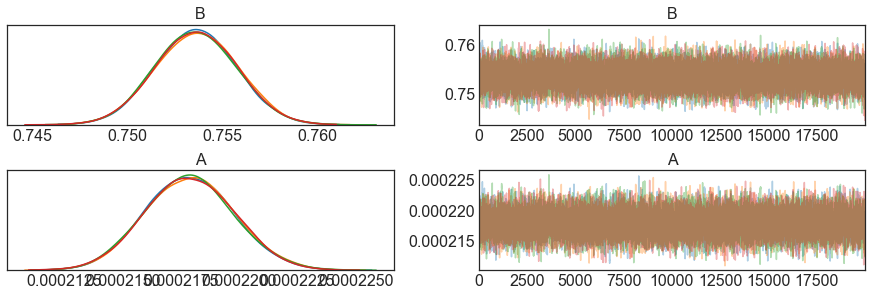

In [14]:
pm.traceplot(trace)

In [21]:
A_mean=trace['A'].mean()
dA=trace['A'].std()
B_mean=trace['B'].mean()
dB=trace['B'].std()
tau_mean = -delta_t/np.log(B_mean)
dtau = delta_t*dB/B_mean/np.log(B_mean)**2
print(A_mean,dA,B_mean,dB,tau_mean,dtau)

0.00021784542698163962 1.8851488126155183e-06 0.7535996006446616 0.0021123916898979573 0.0001767445928926823 1.751281899998372e-06


In [30]:
data_norm = datan/np.sqrt(A_mean)
# compile model for reuse
with pm.Model() as model:
    B = pm.Beta('B', alpha=1.0,beta=1.0)
    A = pm.Gamma('A',alpha=1.0,beta=1.0)
    sigma = pm.Uniform('sigma',lower=0,upper=0.5)

    path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(data_norm))
    dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=data_norm)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [1:29:49<00:00,  1.86draws/s]
The acceptance probability does not match the target. It is 0.9454630367813108, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9291117405276046, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [31]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
path[0],-0.089,0.039,-0.162,-0.014,0.000,0.000,13649.0,8186.0,13463.0,293.0,1.03
path[1],0.500,0.041,0.427,0.581,0.000,0.000,11992.0,11890.0,12098.0,237.0,1.03
path[2],0.353,0.040,0.276,0.429,0.000,0.000,14329.0,14263.0,14320.0,369.0,1.03
path[3],0.193,0.041,0.110,0.267,0.000,0.000,12841.0,10892.0,12778.0,262.0,1.04
path[4],0.248,0.040,0.171,0.322,0.000,0.000,11539.0,10971.0,11735.0,266.0,1.04
...,...,...,...,...,...,...,...,...,...,...,...
path[99998],0.164,0.041,0.090,0.246,0.000,0.000,10968.0,9879.0,11014.0,239.0,1.03
path[99999],-0.218,0.041,-0.295,-0.143,0.000,0.000,10862.0,10530.0,11223.0,311.0,1.03
B,0.754,0.002,0.750,0.758,0.000,0.000,943.0,943.0,940.0,2216.0,1.01
A,0.998,0.008,0.982,1.014,0.000,0.000,1070.0,1070.0,1072.0,2152.0,1.01


KeyboardInterrupt: 

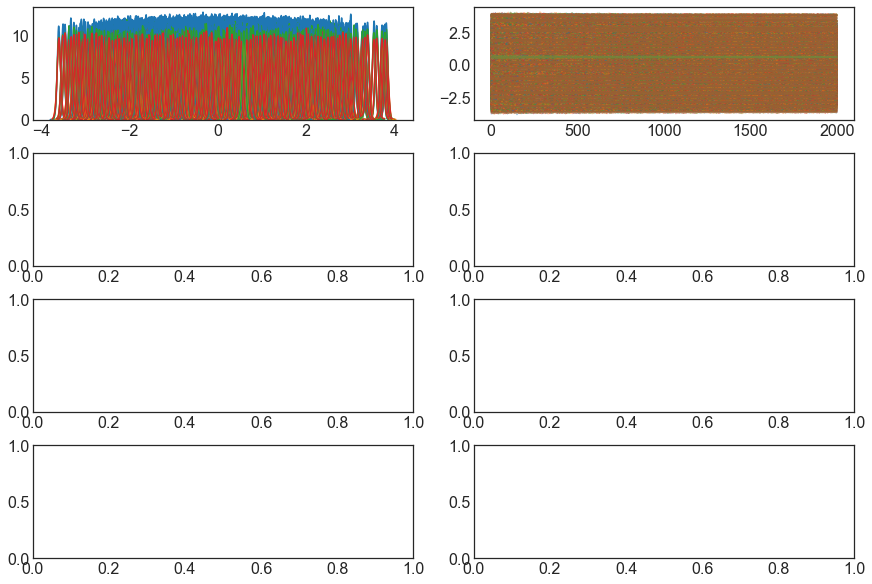

In [32]:
pm.traceplot(trace)

In [ ]:
avgpath = np.mean(trace['path'],axis=0)
stdpath = np.std(trace['path'],axis=0)
print(avgpath.shape)

In [ ]:
plt.plot(data-avgpath)
print(np.std(data-avgpath))

In [ ]:
plt.plot(dataN-data)
print(np.std(dataN-data))

In [ ]:
plt.plot(stdpath)
print(stdpath.mean())

In [102]:
AA,DD = 1.0,1.0
sN = 0.5
total_noise = np.sqrt(AA+sN**2)
print("total noise: ",total_noise)
delta_t_list=np.linspace(0.01,4,50)
#M=1000 # number of data sets
N=2000 # length of data set
#print(np.exp(-delta_t*D/A))

total noise:  1.118033988749895


In [85]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=AA, D=DD, delta_t=delta_t, N=N)
    dataN = data + np.random.normal(loc=0.0, scale=sN, size=N)
    with pm.Model() as model:
        B = pm.Beta('B', alpha=5.0,beta=1.0)
        A = pm.Uniform('A', lower=0, upper=a_bound)
        sigma = pm.Uniform('sigma',lower=0,upper=5)

        path = Ornstein_Uhlenbeck('path',A=A, B=B,shape=len(dataN))
        dataObs = pm.Normal('dataObs',mu=path,sigma=sigma,observed=dataN)
        trace = pm.sample(2000)
        
    a_mean = trace['A'].mean()
    b_mean = trace['B'].mean()
    a_std = trace['A'].std()
    b_std = trace['B'].std()
    sigma_mean = trace['sigma'].mean()
    sigma_std = trace['sigma'].std()
    avgpath = np.mean(trace['path'],axis=0)
    stddiff = np.std(data-avgpath)
    stdpath = np.std(trace['path'],axis=0).mean()
    
    results = [a_mean,a_std,b_mean,b_std,sigma_mean,sigma_std,stddiff,stdpath]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:17<00:00, 72.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


0.09142857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:46<00:00, 213.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


0.17285714285714288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:49<00:00, 202.24draws/s]
The number of effective samples is smaller than 25% for some parameters.


0.2542857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:38<00:00, 260.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


0.33571428571428574


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:45<00:00, 218.85draws/s]
The number of effective samples is smaller than 10% for some parameters.


0.41714285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:42<00:00, 235.95draws/s]
The number of effective samples is smaller than 10% for some parameters.


0.4985714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:37<00:00, 268.94draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0.5800000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:35<00:00, 282.96draws/s]
The acceptance probability does not match the target. It is 0.6640191185143672, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0.6614285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:33<00:00, 300.38draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


0.7428571428571429


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 5 divergences: 100%|██████████| 10000/10000 [00:33<00:00, 297.60draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6980552172292815, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


0.8242857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:51<00:00, 194.99draws/s]
The acceptance probability does not match the target. It is 0.6525859556269771, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


0.9057142857142858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:38<00:00, 256.78draws/s]
The acceptance probability does not match the target. It is 0.7192832433128111, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


0.9871428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 28 divergences: 100%|██████████| 10000/10000 [00:42<00:00, 234.77draws/s]
The acceptance probability does not match the target. It is 0.6948161377217118, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47882319921566263, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.0685714285714287


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:40<00:00, 244.26draws/s]
The acceptance probability does not match the target. It is 0.6581521457478888, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6956812626745382, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


1.1500000000000001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 2 divergences: 100%|██████████| 10000/10000 [00:42<00:00, 233.24draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.2314285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:47<00:00, 212.31draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.312857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:45<00:00, 219.01draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.3942857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:46<00:00, 216.44draws/s]
The acceptance probability does not match the target. It is 0.6710803520943539, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.4757142857142858


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 5 divergences: 100%|██████████| 10000/10000 [00:48<00:00, 205.37draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6934024381530582, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6852725810103365, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7030110052004772, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective s

1.5571428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:40<00:00, 248.11draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


1.6385714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 4 divergences: 100%|██████████| 10000/10000 [00:55<00:00, 181.31draws/s]
The acceptance probability does not match the target. It is 0.5910260697272723, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7055257383039877, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7198369420994941, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


1.7200000000000002


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:39<00:00, 250.98draws/s]
The acceptance probability does not match the target. It is 0.6940316934946712, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7100344570373643, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.8014285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 3 divergences: 100%|██████████| 10000/10000 [00:45<00:00, 222.11draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6700089549053334, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


1.882857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:48<00:00, 206.63draws/s]
The acceptance probability does not match the target. It is 0.6917931000331292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6601446414640424, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


1.9642857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 23 divergences: 100%|██████████| 10000/10000 [00:44<00:00, 223.74draws/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6177972952590962, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6244682077634804, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894925163024149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7181985073825966, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimat

2.045714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 22 divergences: 100%|██████████| 10000/10000 [00:42<00:00, 237.41draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6968121314937902, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5503725878640895, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


2.1271428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:44<00:00, 222.78draws/s]
The acceptance probability does not match the target. It is 0.6299917481209413, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2.2085714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 106 divergences: 100%|██████████| 10000/10000 [00:32<00:00, 307.42draws/s]
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5314943570005327, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5429243774527994, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2.29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 88 divergences: 100%|██████████| 10000/10000 [00:46<00:00, 214.61draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5164815255072401, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5346101254247814, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29786322940585036, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some paramet

2.3714285714285714


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 23 divergences: 100%|██████████| 10000/10000 [00:37<00:00, 266.76draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7038729658942227, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


2.452857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,738 divergences: 100%|██████████| 10000/10000 [00:51<00:00, 193.10draws/s]
The acceptance probability does not match the target. It is 0.6306746037774664, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44150831572606436, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1686 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10302195322980978, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the ta

2.5342857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 38 divergences: 100%|██████████| 10000/10000 [00:37<00:00, 267.42draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5830478573942026, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5620552843215928, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4241942106193511, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. 

2.6157142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 237 divergences: 100%|██████████| 10000/10000 [00:44<00:00, 223.53draws/s]
The acceptance probability does not match the target. It is 0.47618837454540125, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7029787495466048, but should be close to 0.8. Try to increase the number of tuning steps.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43195374347393506, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target.

2.697142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,481 divergences: 100%|██████████| 10000/10000 [00:38<00:00, 257.29draws/s]
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34152034477121845, but should be close to 0.8. Try to increase the number of tuning steps.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.313112241088505, but should be close to 0.8. Try to increase the number of tuning steps.
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.463426786396113, but should be close to 0.8. Try to increase the number of tuning steps.
There were 644 divergences after tuning. Increase

2.7785714285714285


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 867 divergences: 100%|██████████| 10000/10000 [00:50<00:00, 197.59draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39871195732223447, but should be close to 0.8. Try to increase the number of tuning steps.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32426207034632787, but should be close to 0.8. Try to increase the number of tuning steps.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34297983869429044, but should be close to 0.8. Try to increase the number of tuning steps.
There were 199 divergences after tuning. Increas

2.86


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 2 divergences: 100%|██████████| 10000/10000 [00:38<00:00, 256.94draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6695904735761614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6653602001399579, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


2.9414285714285713


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 803 divergences: 100%|██████████| 10000/10000 [00:46<00:00, 214.91draws/s]
The acceptance probability does not match the target. It is 0.6299921675679738, but should be close to 0.8. Try to increase the number of tuning steps.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4206003931422535, but should be close to 0.8. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4524163814280895, but should be close to 0.8. Try to increase the number of tuning steps.
There were 666 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target

3.0228571428571427


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 167 divergences: 100%|██████████| 10000/10000 [00:52<00:00, 190.18draws/s]
The acceptance probability does not match the target. It is 0.6945309379395636, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5894783396278976, but should be close to 0.8. Try to increase the number of tuning steps.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39294670523795794, but should be close to 0.8. Try to increase the number of tuning steps.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target

3.104285714285714


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,346 divergences: 100%|██████████| 10000/10000 [00:48<00:00, 207.45draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29253547444313227, but should be close to 0.8. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27246164389569927, but should be close to 0.8. Try to increase the number of tuning steps.
There were 647 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.361987712292889, but should be close to 0.8. Try to increase the number of tuning steps.
There were 538 divergences after tuning. Increas

3.1857142857142855


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 196 divergences: 100%|██████████| 10000/10000 [00:41<00:00, 240.08draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5263792730425672, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39312826236825354, but should be close to 0.8. Try to increase the number of tuning steps.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604457008421161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `ta

3.267142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,102 divergences: 100%|██████████| 10000/10000 [00:51<00:00, 195.00draws/s]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5416383656760005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22399650043660474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6305958694350025, but should be close to 0.8. Try to increase the number of tuning steps.
There were 599 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the ta

3.3485714285714288


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,379 divergences: 100%|██████████| 10000/10000 [00:40<00:00, 248.51draws/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5609226706247241, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3843392028321246, but should be close to 0.8. Try to increase the number of tuning steps.
There were 701 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2504730237427591, but should be close to 0.8. Try to increase the number of tuning steps.
There were 523 divergences after tuning. Increase

3.43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 697 divergences: 100%|██████████| 10000/10000 [00:36<00:00, 272.31draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45271547980415267, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40549402501919474, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6142202627839791, but should be close to 0.8. Try to increase the number of tuning steps.
There were 610 divergences after tuning. Increase `tar

3.5114285714285716


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 474 divergences: 100%|██████████| 10000/10000 [00:39<00:00, 252.50draws/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48840938967826214, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45205181888649665, but should be close to 0.8. Try to increase the number of tuning steps.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3459353859283875, but should be close to 0.8. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `

3.592857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 471 divergences: 100%|██████████| 10000/10000 [00:49<00:00, 200.97draws/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31420439197333994, but should be close to 0.8. Try to increase the number of tuning steps.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30474269859285064, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5423283776262252, but should be close to 0.8. Try to increase the number of tuning steps.
There were 156 divergences after tuning. Increase

3.6742857142857144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 274 divergences: 100%|██████████| 10000/10000 [00:36<00:00, 271.51draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6308139948780492, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4192264664431626, but should be close to 0.8. Try to increase the number of tuning steps.
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47174771665635035, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target

3.755714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 920 divergences: 100%|██████████| 10000/10000 [00:45<00:00, 217.44draws/s]
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3485509628603022, but should be close to 0.8. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5567535406895027, but should be close to 0.8. Try to increase the number of tuning steps.
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35977175804593525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 97 divergences after tuning. Increase `

3.837142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 1,110 divergences: 100%|██████████| 10000/10000 [00:42<00:00, 235.68draws/s]
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37180195398419763, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5449386238869827, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3436098771149524, but should be close to 0.8. Try to increase the number of tuning steps.
There were 973 divergences after tuning. Increase `

3.9185714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 189 divergences: 100%|██████████| 10000/10000 [00:34<00:00, 287.41draws/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48692516151519827, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5147053191432638, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5527403276099869, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `t

4.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [path, sigma, A, B]
Sampling 4 chains, 56 divergences: 100%|██████████| 10000/10000 [00:37<00:00, 267.91draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4371630298141488, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5511946067498134, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5873166349625069, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some paramet

In [86]:
tau = -delta_t_list/np.log(result_array.T[2])
dtau = delta_t_list*result_array.T[3]/result_array.T[2]/np.log(result_array.T[2])**2


Text(0, 0.5, '$\\sigma_{GT-model}$')

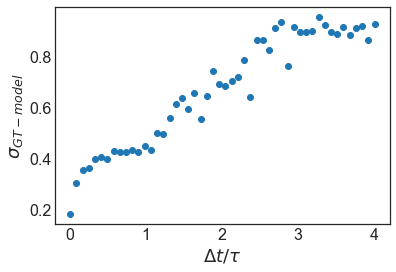

In [95]:
plt.plot(delta_t_list,result_array.T[6],"o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{GT-model}$')

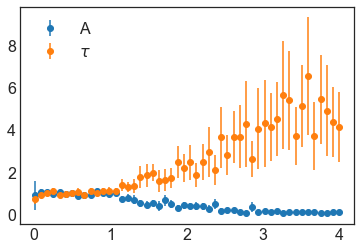

In [99]:
plt.errorbar(delta_t_list,result_array.T[0],yerr=result_array.T[1],fmt="o",label="A")
plt.errorbar(delta_t_list,tau,dtau,fmt="o",label=r'$\tau$')
plt.legend(loc="upper left")

Text(0, 0.5, '$\\sigma_{noise}$')

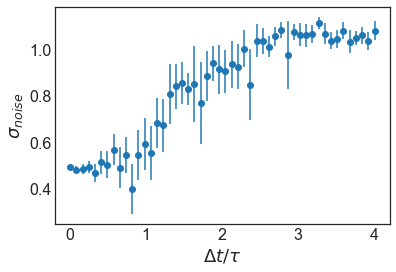

In [101]:
plt.errorbar(delta_t_list,result_array.T[4],yerr=result_array.T[5],fmt="o")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel(r'$\sigma_{noise}$')